# Test: `xgboost`

## Env. Setting

### Modules

1. Module Import 
2. Version Check
3. Font: `DejaVu`


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

import sklearn as skl
from sklearn.base import TransformerMixin
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

import xgboost as xgb
# from xgboost.compat import XGBLabelEncoder
# => is IDENTICAL to `sklearn.preprocessing.LabelEncoder`

import lime
from lime import lime_tabular

import pdpbox
from pdpbox import pdp, info_plots


for _pkg in [np, pd, mpl, skl, xgb, lime, pdpbox]:
    if hasattr(_pkg, '__version__'):
        print(f'{_pkg.__package__:<7} = {_pkg.__version__}')


font_dict = {
    path.split('/')[-1][:-4]: path
    for path in fm.get_fontconfig_fonts()
    if 'dejavu' in path.lower().split('/')[-1]
}

plt.rcParams['font.family'] = sorted(font_dict.keys(), key=len)[0]


# os.chdir('../git/xgboost-lime-pdp')
fpath = '..'

numpy   = 1.16.3
pandas  = 0.24.2
matplotlib = 2.2.4
sklearn = 0.21.1
xgboost = 0.82
pdpbox  = 0.2.0


In [2]:
%pip show lime

Name: lime
Version: 0.1.1.34
Summary: Local Interpretable Model-Agnostic Explanations for machine learning classifiers
Home-page: http://github.com/marcotcr/lime
Author: Marco Tulio Ribeiro
Author-email: marcotcr@gmail.com
License: BSD
Location: /home/pydemia/apps/anaconda3/envs/sparkml-xgboost-lime-test/lib/python3.6/site-packages
Requires: scikit-image, numpy, matplotlib, scikit-learn, scipy
Required-by: 
Note: you may need to restart the kernel to use updated packages.


### Classes & Functions

<div class="alert alert-block alert-warning">

<b>$\cdot$ `as_int`, `as_int_str`, `as_float`</b>: 데이터 load 시 Column data type 지정
</div>

```py
col_converter = {'USE_YN': as_int_str, 'SCORE': as_float}
data = pd.read_csv(filename, converters=col_converter, ...)
```
<div class="alert alert-block alert-warning">

<b>$\cdot$ `DataFrameImputer`</b>: 결측값 대체
</div>

```py
data = pd.concat(...)
data = DataFrameImputer().fit_transform(data)

```

<div class="alert alert-block alert-warning">

<b>$\cdot$ `preprocess_by_column`</b>: 데이터 전처리(String Categorization 포함)
</div>

```py
XY, col_types_dict, category_dict, float_scaler = preprocess_by_column(XY)
```

* read_dtype_converter

In [3]:
def as_int(string):
    return np.fromstring(string, dtype=np.int64, sep=',')[0]

def as_int_str(string):
    return np.fromstring(string, dtype=np.int64, sep=',').astype(np.str)[0]

def as_str(string):
    return np.fromstring(string, dtype=np.str, sep=',')[0]

* Class `DataFrameImputer`: In case of Filling missing values

In [4]:
class DataFrameImputer(TransformerMixin):
    """Fill missing values.

    Columns of dtype object are imputed with the most frequent value 
    in column.
    Columns of other types are imputed with mean of column.

    """

    def __init__(self):
        super().__init__()

    def fit(self, X, y=None):

        self.fill = pd.Series(
            [
                X[c].value_counts().index[0]
                if X[c].dtype == np.dtype('O')
                else X[c].mean()
                for c in X
            ],
            index=X.columns,
        )
        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

* Function `preprocess_by_column`: Column Typing & Categorization

In [5]:
def preprocess_by_column(dataframe):
    """Column Typing & Categorization.

    If a column has `float`, it will be min-max scaled.
    If a column has `str`, it will be categorized & substitute by int, which is its code number.
    If a column has `int`, do nothing.
    
    Parameters
    ----------
    dataframe: pandas.DataFrame
        Data to preprocess.
    
    Return
    ------
    dataframe: pandas.DataFrame
        Preprocessed Data.
            
    col_dict: dict
        A dictionary of column lists by its dtype.
    
    float_scaler: sklearn.preprocessing.MinMaxScaler
        A MinMaxScaler instance of `float` type columns. 
    
    """
    grouped = dataframe.columns.to_series().groupby(dataframe.dtypes).groups
    col_types = {
        dtype.name: colname_list.tolist()
        for dtype, colname_list in grouped.items()
    }
    float_columns = col_types.get('float64', [])
    int_columns = col_types.get('int64', [])
    str_columns = col_types.get('object', [])
    cat_columns = int_columns + str_columns

    if bool(cat_columns):
        dataframe[cat_columns] = dataframe[cat_columns].astype('category')
        category_codes_df = (
            dataframe[cat_columns].apply(lambda x: x.cat.codes)
        )
        category_names_df = (
            dataframe[cat_columns].apply(lambda x: x.cat.categorical)
        )
        category_dict = (
            dataframe
            [cat_columns]
            .agg(lambda x: [x.cat.categories.tolist()])
            .to_dict('records')
        )[0]
        dataframe[cat_columns] = category_codes_df

    else:
        category_dict = {}

    if float_columns is not None:
        float_scaler = MinMaxScaler(feature_range=(0, 1))
        dataframe[float_columns] = float_scaler.fit_transform(
            dataframe[float_columns]
        )

    col_dict = {
        'float': float_columns,
        'category': cat_columns,
    }

    return dataframe, col_dict, category_dict, float_scaler

## Load Data

<div class="alert alert-block alert-warning">
<b> Data 선택  </b><br>

<b>CASE</b> = 1 또는 2<br>
- 1: data by .<br>
- 2: data by ..<br>

<b>COLNAMES_TO_FLIKE</b> = True 또는 False<br>
- True : colA, colB, colC, ... -> f0, f1, f2, ...<br>
- False: colA, colB, colC, ... -> colA, colB, colC, ...<br>

해당 ARGUMENT로 데이터 선택 및 전처리<br>

</div>

### File Path (Case `1` & `2`)

In [6]:
CASE = 1
COLNAMES_TO_FLIKE = True

In [7]:
if int(CASE) == 1:
    DUMP_PATH = f'{fpath}/data/nativeBoost2'
    train_filename = f'{fpath}/data/train_63qYitG.csv'
    test_filename = f'{fpath}/data/test_XaoFywY.csv'

elif int(CASE) == 2:
    DUMP_PATH = f'{fpath}/data/nativeBoost6features'
    train_filename = f'{fpath}/data/train_new.csv'
    test_filename = f'{fpath}/data/test_new.csv'

else:
    raise ValueError('`CASE` Should be int `1` or int `2`.')

### Loading

In [8]:
if int(CASE) == 1:

    int_type_colnames = ['Surge_Pricing_Type', 'Var3']
    col_converter = {colname: as_int_str for colname in int_type_colnames}

    train_df = pd.read_csv(
        train_filename, header=0, converters=col_converter,
    )
    test_df = pd.read_csv(
        test_filename, header=0, converters=col_converter,
    )

    data = pd.concat(
        [train_df, test_df],
        axis=0,
        ignore_index=True,
    )
    data = DataFrameImputer().fit_transform(data)
    data = data.drop(
        [
            'Trip_ID',
            'Cancellation_Last_1Month',
            'Confidence_Life_Style_Index',
            'Gender',
            'Life_Style_Index',
            'Var1',
            'Var2',
        ],
        axis=1,
    )

    y_cols = target_names = ['Surge_Pricing_Type']


elif int(CASE) == 2:
    int_type_colnames = ['c1', 'c2', 'c6', 'r1']
    col_converter = {colname: as_int_str for colname in int_type_colnames}

    X = train_df = pd.read_csv(
        train_filename, header=0, converters=col_converter,
    )
    Y = test_df = pd.read_csv(
        test_filename, header=0, converters=col_converter,
    )
    data = pd.concat([X, Y], axis=1)
    
    y_cols = target_names = ['r1']


x_cols = feature_names = data.columns.drop(target_names).tolist()
xy_cols = x_cols + y_cols
data = data[xy_cols]
print(data.columns)

if COLNAMES_TO_FLIKE:
    data.columns = [f"f{i}" for i in range(len(data.columns))]
    y_cols = target_names = [data.columns[-1]]

x_cols = feature_names = data.columns.drop(y_cols).tolist()
xy_cols = data.columns.tolist()

Index(['Customer_Rating', 'Customer_Since_Months', 'Destination_Type',
       'Trip_Distance', 'Type_of_Cab', 'Var3', 'Surge_Pricing_Type'],
      dtype='object')


### Preprocessing

In [9]:
XY, col_types_dict, category_dict, float_scaler = preprocess_by_column(data)

X = source_df = XY[x_cols]
Y = target_df = XY[y_cols]
Y_series = target_series = Y[Y.columns[0]]

print(target_names)

['f6']


## Loading a pre-trained Model: `xgboost`

### 진행 과정

1. `xgb.Booster`:  
    `predict_proba` 없음.
<br>

2. `xgb.XGBClassifier`:  
    - `predict_proba` 결과 shape가 기대와 다름. `(4, 176426)`  
    - `predict`는 정상적으로 출력 `(88213,)`

<br>

3. `xgb.XGBModel`(`xgb.XGBClassifier`의 `super class`):   
    - `predict_proba` 대신 `predict` 활용하여 `lime`에 적용. 성공.
      - `lime` Documentation에 classification은 `predict_proba`를 사용하라고 명시되어 있어 추가 검토 진행.

<br>

4. `xgb.XGBClassifier`에 계속 적용 시도, but `(4, 176426)`.
    - Q1: 왜 Label 개수에 해당하는 axis가 4인지?: (data 내 DISTINCT COUNT는 3)
    - Q2: 왜 `176426`인지?: data record 개수인 `88213`의 2배

### Test: `XGBModel`

In [10]:
# %% Load a pre-trained Model ------------------------------------------------
model = xgb.XGBModel()
model.load_model(DUMP_PATH)
model.n_classes_ = len(np.unique(Y.values))
model._le = LabelEncoder().fit(np.unique(Y.values))

print(model)
print('X: ', X.shape)
print('Y unique: ', len(np.unique(Y)), np.unique(Y))
# print('predict_proba: ', model.predict_proba(X).shape)
print('predict: ', model.predict(X).shape)
model.predict(X[:5])

XGBModel(base_score=0.5, booster='gbtree', colsample_bylevel=1,
         colsample_bytree=1, gamma=0, importance_type='gain', learning_rate=0.1,
         max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
         n_estimators=100, n_jobs=1, nthread=None, objective='reg:linear',
         random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
         seed=None, silent=True, subsample=1)
X:  (219057, 6)
Y unique:  3 [0 1 2]
predict:  (219057, 4)


array([[0.36621702, 0.20990732, 0.21842004, 0.20545565],
       [0.36621702, 0.20990732, 0.21842004, 0.20545565],
       [0.35622832, 0.20418203, 0.23973788, 0.19985178],
       [0.36621702, 0.20990732, 0.21842004, 0.20545565],
       [0.3837856 , 0.20408864, 0.21236539, 0.19976035]], dtype=float32)

### Test: `XGBClassifier`

In [11]:
# %% Load a pre-trained Model ------------------------------------------------

model = xgb.XGBClassifier()
model.load_model(DUMP_PATH)
model.n_classes_ = len(np.unique(Y.values))
model._le = LabelEncoder().fit(np.unique(Y.values))

print(model)
print('X: ', X.shape)
print('Y unique: ', len(np.unique(Y)), np.unique(Y))
print('predict_proba: ', model.predict_proba(X).shape)
print('predict: ', model.predict(X).shape)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)
X:  (219057, 6)
Y unique:  3 [0 1 2]
predict_proba:  (4, 438114)
predict:  (219057,)


### Test without DUMP: A New Dummy Model

In [12]:
from sklearn.datasets import load_iris

aa = load_iris()

In [13]:
tmp_X = pd.DataFrame(aa['data'], columns=aa['feature_names'])
tmp_Y = pd.DataFrame(aa['target'], columns=['Y'], dtype=str)
tmp_XY = pd.concat([tmp_X, tmp_Y], axis=1)

print(np.unique(tmp_Y.values))
print(aa['target_names'])

['0' '1' '2']
['setosa' 'versicolor' 'virginica']


In [14]:
model = xgb.XGBClassifier()
model.fit(X=tmp_X, y=tmp_Y['Y'])

print(model)
print('X: ', tmp_X.shape)
print('Y unique: ', len(np.unique(tmp_Y['Y'])), np.unique(tmp_Y['Y']))
print('predict_proba: ', model.predict_proba(tmp_X).shape)
print('predict: ', model.predict(tmp_X).shape)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=1, nthread=None, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)
X:  (150, 4)
Y unique:  3 ['0' '1' '2']
predict_proba:  (150, 3)
predict:  (150,)


<div class="alert alert-block alert-danger">

`objective`<b> Parameter 차이:</b><br> 

iris로 만든 dummy model은 `objective='multi:softprob'`값인데,<br>
loaded model은 `objective='binary:logistic'`로 읽어들인다.<br>
<br>

<b>Y class 개수도 3개: Load 한 Model parameter가 아님.</b><br>
: binary classification보다는 multiclass일 것. <br>
</div>

<div class="alert alert-block alert-info">
<b>Tip:</b> spark 내에서 XGBoost 동작 시 <b><i>Dummy class 1개 </i></b>가 추가되어 학습되고,<br>
그 결과 <b>Y Class 개수</b>가 <b>3 + 1 = 4</b> 로 보이게 됨.<br>
</div>

[Link to `objective`](https://xgboost.readthedocs.io/en/latest/parameter.html)

In [15]:
"""Test: `predict_proba`.

`class_probs` is equal to the result of `predict`, but

if self.objective == "multi:softprob":
    return class_probs
classone_probs = class_probs
classzero_probs = 1.0 - classone_probs
return np.vstack((classzero_probs, classone_probs)).transpose()

"""

for _objective in ['binary:logistic', 'multi:softprob']:
    model = xgb.XGBClassifier(objective=_objective,)
    model.fit(X=tmp_X, y=tmp_Y['Y'])
    model.objective = _objective

    print(model)
    print('X: ', tmp_X.shape)
    print('Y unique: ', len(np.unique(tmp_Y['Y'])), np.unique(tmp_Y['Y']))
    print('predict_proba: ', model.predict_proba(tmp_X).shape)
    print('predict: ', model.predict(tmp_X).shape)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)
X:  (150, 4)
Y unique:  3 ['0' '1' '2']
predict_proba:  (3, 300)
predict:  (150,)
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=1, nthread=None, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)
X:  (150, 4)
Y unique:  3 ['0' '1' '2']
predict_proba:  (150, 3)
predict:

In [16]:
# %% Load a pre-trained Model ------------------------------------------------

model = xgb.XGBModel()
model.load_model(DUMP_PATH)
model.n_classes_ = len(np.unique(Y.values))
model._le = LabelEncoder().fit(np.unique(Y.values))

print(model)
print('X: ', X.shape)
print('Y unique: ', len(np.unique(Y)), np.unique(Y))
# print('predict_proba: ', model.predict_proba(X).shape)
print('predict: ', model.predict(X).shape)
model.predict(X[:5])

XGBModel(base_score=0.5, booster='gbtree', colsample_bylevel=1,
         colsample_bytree=1, gamma=0, importance_type='gain', learning_rate=0.1,
         max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
         n_estimators=100, n_jobs=1, nthread=None, objective='reg:linear',
         random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
         seed=None, silent=True, subsample=1)
X:  (219057, 6)
Y unique:  3 [0 1 2]
predict:  (219057, 4)


array([[0.36621702, 0.20990732, 0.21842004, 0.20545565],
       [0.36621702, 0.20990732, 0.21842004, 0.20545565],
       [0.35622832, 0.20418203, 0.23973788, 0.19985178],
       [0.36621702, 0.20990732, 0.21842004, 0.20545565],
       [0.3837856 , 0.20408864, 0.21236539, 0.19976035]], dtype=float32)

<div class="alert alert-block alert-success">
<b>$\divideontimes$ 정상 Load 확인 </b><br>

`objective='multi:softprob'`로 Multiclass 확률을 제대로 출력할 수 있게 재정의.<br>
</div>

__`xgboost.sklearn.XGBClassifier`의 `predict`, `predict_proba` Methods 발췌:__

```py
# output_margin=False (default라 둘 다 같은 값이 들어감)

def predict(...):
    ...
    class_probs = self.get_booster().predict(test_dmatrix,
                                             output_margin=output_margin,
                                             ntree_limit=ntree_limit,
                                             validate_features=validate_features)


    if output_margin:
        # If output_margin is active, simply return the scores
        return class_probs

    if len(class_probs.shape) > 1:
        column_indexes = np.argmax(class_probs, axis=1)
    else:
        column_indexes = np.repeat(0, class_probs.shape[0])
        column_indexes[class_probs > 0.5] = 1
    return self._le.inverse_transform(column_indexes)
```


```py
def predict_proba(...):
    ...
    class_probs = self.get_booster().predict(test_dmatrix,
                                             ntree_limit=ntree_limit,
                                             validate_features=validate_features)

    if self.objective == "multi:softprob":
        return class_probs   # `iris` 결과: (150, 3)

    # 문제가 되는 부분 ---------------------------------------------------------------
    classone_probs = class_probs  # (150, 3)
    classzero_probs = 1.0 - classone_probs  # (150, 3)
    return np.vstack((classzero_probs, classone_probs)).transpose()  # (3, 300)
    # ----------------------------------------------------------------------------

    """코드 해석 ===================================================================
    binary classification일 때, 0 또는 1에 대한 확률 모두를 multiclass 확률처럼 출력하기 위한 과정 (구현 문제로 판단)

    # classone_probs : 1일 확률
    # classzero_probs: 0일 확률 (전체확률 - 1일 확률)
    
    return 값 해석
    ============
    (150, 3) 2개를 vstack해서 (300, 3)으로 만들고, transpose하여 (3, 300)으로 변환됨.
    
    """
```


```py
>>> le = preprocessing.LabelEncoder()
>>> le.fit(["paris", "paris", "tokyo", "amsterdam"])
LabelEncoder()
>>> list(le.classes_)
['amsterdam', 'paris', 'tokyo']
>>> le.transform(["tokyo", "tokyo", "paris"]) 
array([2, 2, 1]...)
>>> list(le.inverse_transform([2, 2, 1]))
['tokyo', 'tokyo', 'paris']
```

### The Proper Way: `objective='multi:softprob'`

In [17]:
# %% Load a pre-trained Model ------------------------------------------------

model = xgb.XGBClassifier(objective='multi:softprob')
model.load_model(DUMP_PATH)
model.n_classes_ = len(np.unique(Y.values))
model._le = LabelEncoder().fit(np.unique(Y.values))

print(model)
print('X: ', X.shape)
print('Y unique: ', len(np.unique(Y)), np.unique(Y))
print('predict_proba: ', model.predict_proba(X).shape)
print('predict: ', model.predict(X).shape)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=1, nthread=None, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)
X:  (219057, 6)
Y unique:  3 [0 1 2]
predict_proba:  (219057, 4)
predict:  (219057,)


* Load 할 경우 `None`으로 남아있는 `n_classes` 강제 설정.

In [18]:
model.n_classes_ = len(np.unique(Y.values))

<div class="alert alert-block alert-warning">
    <b>$\divideontimes$ 추가 검토사항: </b> <b>LabelEncoder 값</b>을 다시 <i>fit</i> 하는 게 아니고(Y 전체 값이 필요),
<b>기존 spark의 <i>LabelPoint 값</i></b> 으로 활용하는 방안 고려<br>
</div>

### `sklearn.preprocessing.LabelEncoder` 설명



* Prepare Data:
```py
>>> class_list = ['setosa', 'versicolor', 'virginica']
>>> class_list
['setosa', 'versicolor', 'virginica']
```

* Create a new `LabelEncoder`:
```py
>>> from sklearn.preprocessing import LabelEncoder
>>> lle = LabelEncoder()
```

* Train(fit) an `LabelEncoder`
```py
>>> lle.fit(class_list)
LabelEncoder()
```

* Show trained classes IN ORDER.
```py
>>> list(lle.classes_)
['setosa', 'versicolor', 'virginica']
```

* Decode: From `number(int)` to `category(string)`:
```py
>>> lle.inverse_transform([1, 0, 2, 1])
array(['versicolor', 'setosa', 'virginica', 'versicolor'], dtype='<U10')
```

* Encode: From `category(string)` to `number(int)`:
```py
>>> lle.transform(['virginica', 'setosa', 'versicolor', 'virginica'])
array([2, 0, 1, 2])
```

<div class="alert alert-block alert-success">
<b>$\divideontimes$ LabelEncoder 해결방안: </b><br>
Index: Value 관계를 Python Dictionary로 처리하여, 입력 순서 상관없이 Label에 숫자 지정.<br>
</div>

In [19]:
y_class_dict = {
    2: 'A Grade',
    0: 'B Grade',
    1: 'C Grade',
}
y_class_list = [
    item[1]
    for item in sorted(list(y_class_dict.items()), key=lambda x: x[0])
]
y_class_list

['B Grade', 'C Grade', 'A Grade']

* 기존 Naming

In [20]:
category_dict[target_names[0]]

['1', '2', '3']

* LabelEncoder 재설정

In [21]:
model._le = LabelEncoder().fit(np.unique(list(y_class_dict.keys())))
print('Y unique: ', len(y_class_list), y_class_list)

Y unique:  3 ['B Grade', 'C Grade', 'A Grade']


## Plotting the Model

### Plot: Blackbox Interpretation via `lime`

In [22]:
input_df = X
input_arr = input_df.values
category_colnames = list(category_dict.keys())
# y_category_list = category_dict[target_names[0]]
y_category_list = y_class_list


explainer = lime.lime_tabular.LimeTabularExplainer(
    input_arr,
    mode='classification',
    feature_names=xy_cols,
    class_names=y_category_list,
    categorical_features=category_colnames,
    categorical_names=category_colnames,
    feature_selection='auto', # 'forward_selection', 'lasso_path', 'auto'
    # kernel_width=4,
)

# Get the explanation for Logistic Regression
exp = explainer.explain_instance(
    data_row=input_arr[1],
    predict_fn=model.predict_proba,
    labels=y_class_dict.keys(),
    num_features=4,
    num_samples=3000,
)
exp.save_to_file(f'{fpath}/lime_result.html')
exp.show_in_notebook(show_all=True)

### Plot: Partial Dependence via `pdpbox`

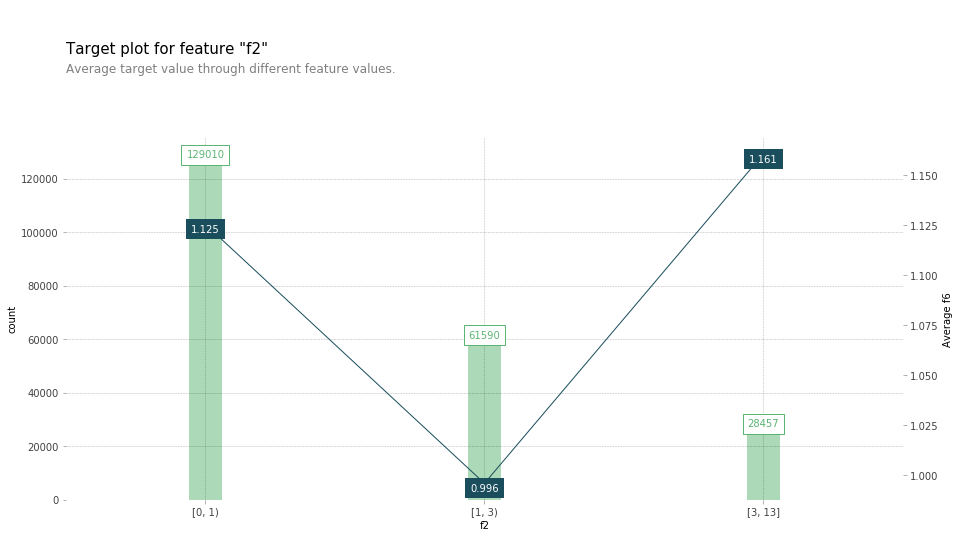

In [23]:
fig, axes, summary_df = info_plots.target_plot(
    df=XY,
    feature=x_cols[2],
    feature_name=x_cols[2],
    target=y_cols[0],
)

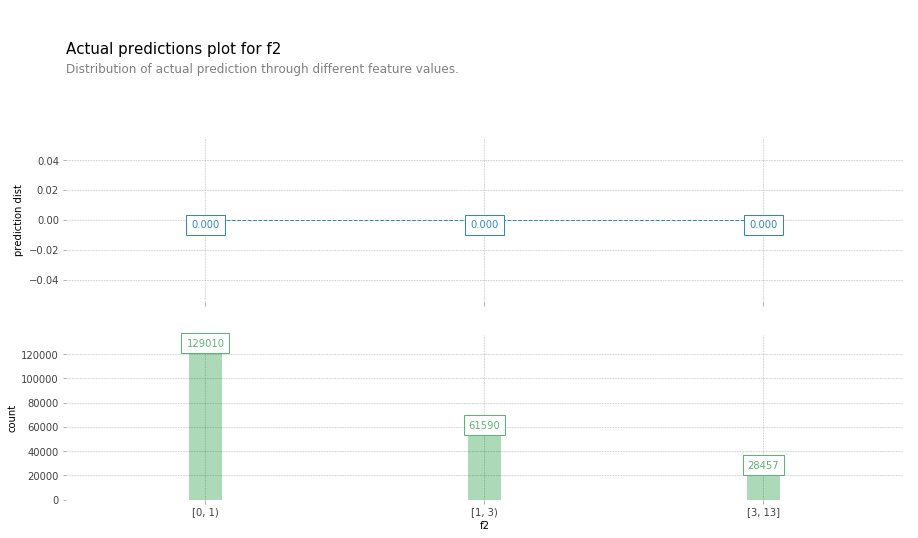

In [24]:
fig, axes, df = info_plots.actual_plot(
    model=model,
    X=X,
    feature=x_cols[2],
    feature_name=x_cols[2],
    # which_classes=None,
    predict_kwds={},  # !This parameter should be passed to avoid a strange TypeError
)

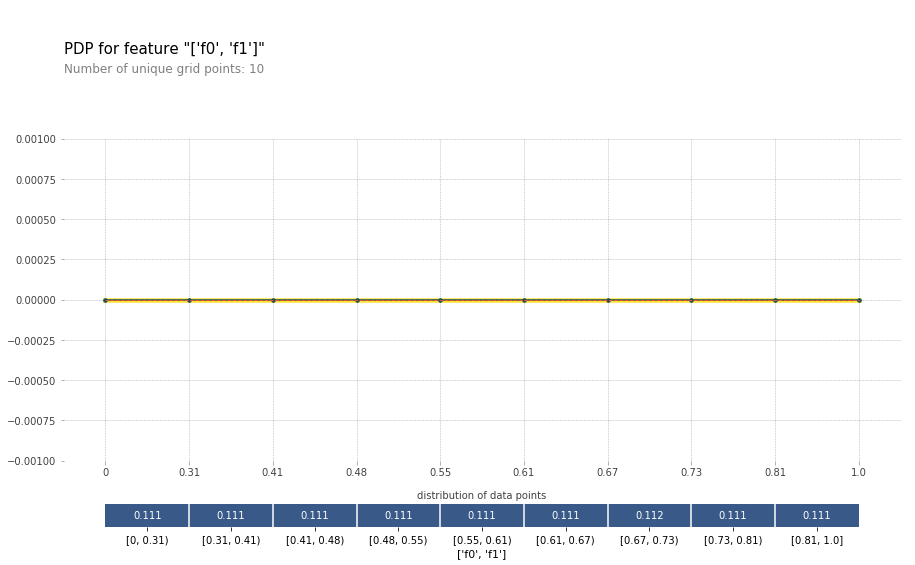

In [25]:
pdp_isolated_tmp = pdp.pdp_isolate(
    model=model,
    dataset=X,
    model_features=x_cols,
    feature=x_cols[0],
    n_jobs=1,
)
fig, axes = pdp.pdp_plot(
    pdp_isolate_out=pdp_isolated_tmp,
    feature_name=x_cols[:2],
    center=True, x_quantile=True,
    ncols=3, plot_lines=True, frac_to_plot=100,
    plot_pts_dist=True,
)

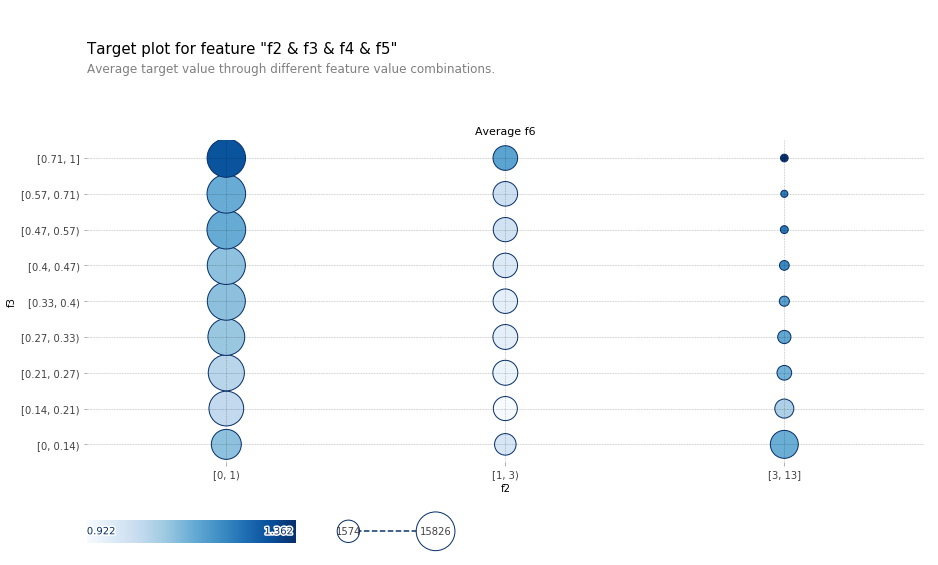

In [26]:
fig, axes, summary_df = info_plots.target_plot_interact(
    df=XY,
    features=x_cols[2:],
    feature_names=x_cols[2:],
    target=y_cols[0],
)

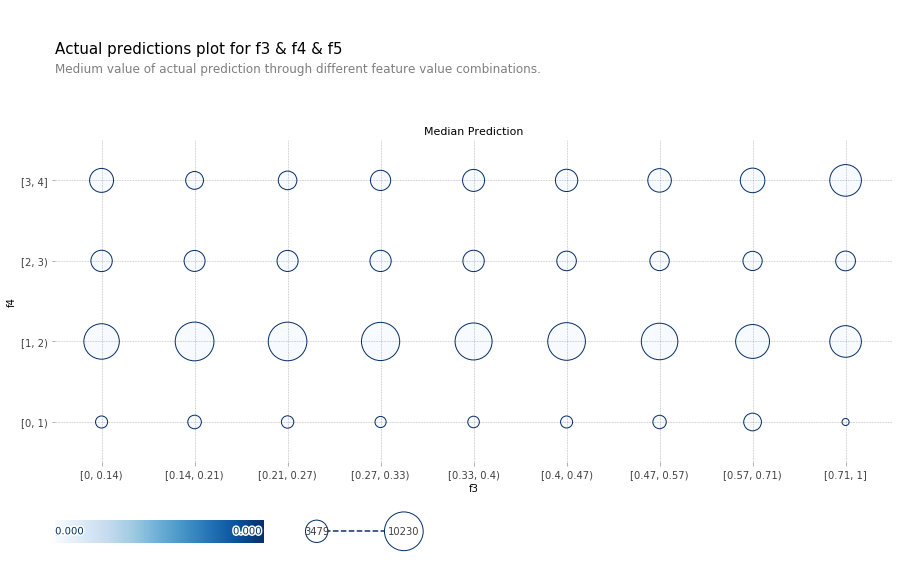

In [27]:
fig, axes, summary_df = info_plots.actual_plot_interact(
    model=model,
    X=X,
    features=x_cols[3:],
    feature_names=x_cols[3:],
    which_classes=[2, 5],
)

In [31]:
X.head()

,f0,f1,f2,f3,f4,f5
0,0.780945,0.1,0,0.059310,1,62
1,0.689922,1.0,0,0.267719,1,80
2,0.700175,1.0,4,0.378902,1,79
3,0.690673,1.0,0,0.562339,2,76
4,0.680420,1.0,0,0.501653,2,2


In [32]:
x_cols

['f0', 'f1', 'f2', 'f3', 'f4', 'f5']

In [28]:
pdp_interacted_tmp= pdp.pdp_interact(
    model=model,
    dataset=X,
    model_features=x_cols,
    features=x_cols[:2],
    num_grid_points=[10, 10],
    percentile_ranges=[None, None],
    n_jobs=1,
)

In [35]:
y_class_dict

{2: 'A Grade', 0: 'B Grade', 1: 'C Grade'}

In [37]:
fig, axes = pdp.pdp_interact_plot(
    pdp_interacted_tmp,
    feature_names=x_cols,
    plot_type='grid',
    x_quantile=True,
    ncols=2,
    plot_pdp=True,
    # which_classes=list(y_class_dict.keys()),
)

ValueError: Both *x_transform* and *y_transform* must be 2D affine transforms

<Figure size 756x900 with 5 Axes>

In [30]:
fig, axes = pdp.pdp_interact_plot(
    pdp_interacted_tmp,
    feature_names=x_cols,
    plot_type='contour',
    x_quantile=True,
    # ncols=1,
    plot_pdp=True,
    which_classes=[1, 2],
)

error_msg = ' '.join(
    [
        "TypeError:",
        "clabel() got an unexpected keyword argument ",
        "'contour_label_fontsize'.",
    ]
)
print(
    "In case of using `matplotlib==3.x`, the following error will be shown:",
    f"`{error_msg}`",
    sep="\n",
)

In case of using `matplotlib==3.x`, the following error will be shown:
`TypeError: clabel() got an unexpected keyword argument  'contour_label_fontsize'.`


ValueError: Both *x_transform* and *y_transform* must be 2D affine transforms

<Figure size 756x900 with 5 Axes>

Done.